# WUM homework 6

Authors: Dawid Płudowski, Antoni Zajko

Revewers: Grzegorz Zakrzewski, Tomasz Modzelewski

## Data preparation

In [2]:
# %load_ext lab_black

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from bioinfokit.visuz import cluster

In [4]:
import os
os.chdir("../")

In [5]:
heart = pd.read_csv("./data/heart.csv")

In [6]:
heart.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


## EDA

In [43]:
heart.shape

(462, 10)

In [7]:
heart.dtypes

sbp            int64
tobacco      float64
ldl          float64
adiposity    float64
famhist       object
typea          int64
obesity      float64
alcohol      float64
age            int64
chd            int64
dtype: object

### Numerical variables

array([[<AxesSubplot:title={'center':'sbp'}>,
        <AxesSubplot:title={'center':'tobacco'}>,
        <AxesSubplot:title={'center':'ldl'}>],
       [<AxesSubplot:title={'center':'adiposity'}>,
        <AxesSubplot:title={'center':'typea'}>,
        <AxesSubplot:title={'center':'obesity'}>],
       [<AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'chd'}>]], dtype=object)

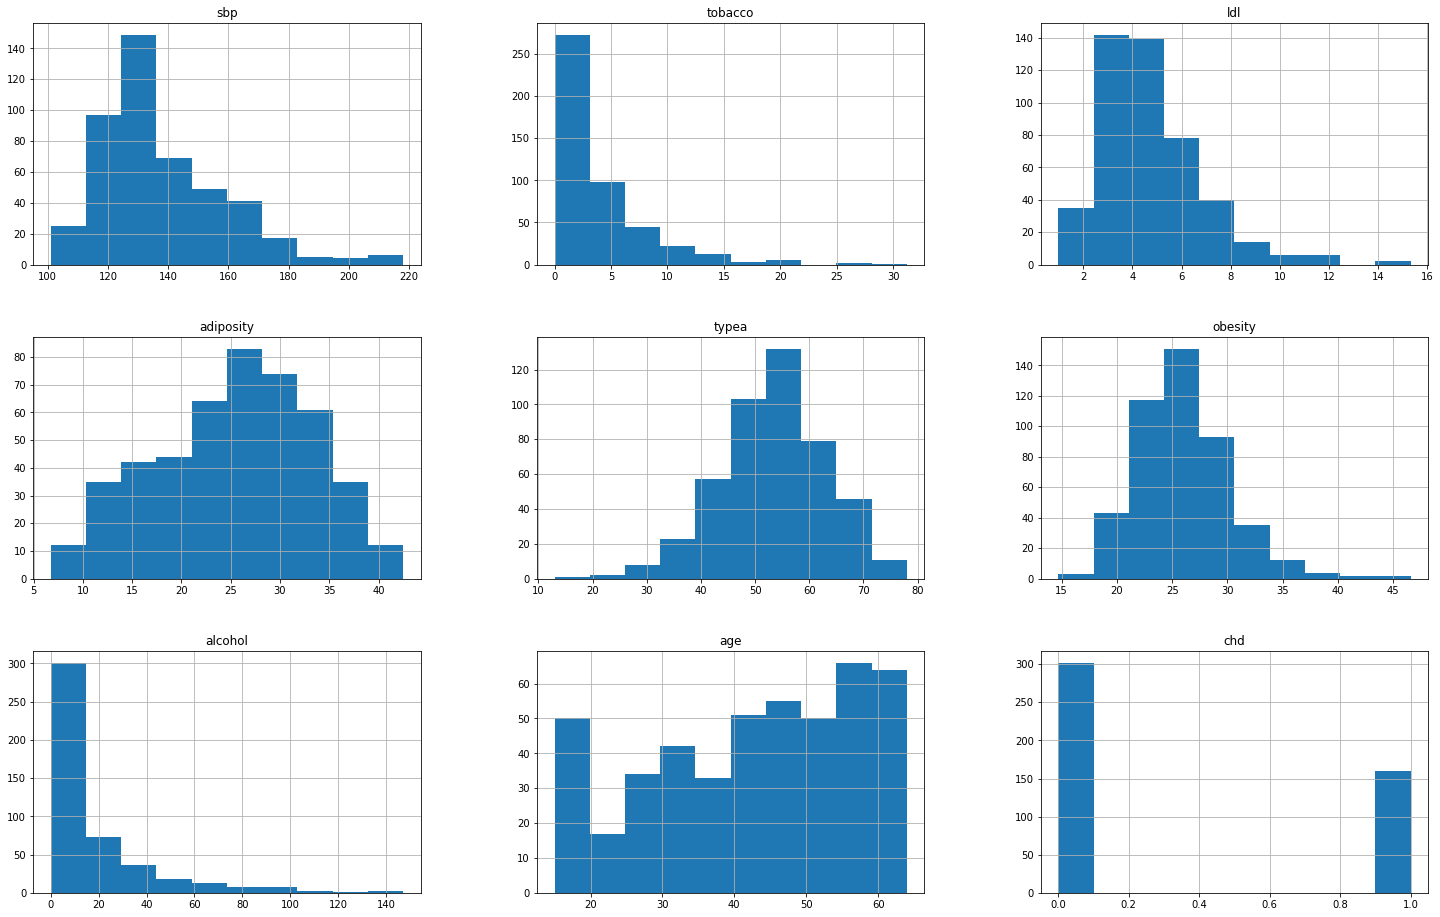

In [8]:
heart.hist(ax = plt.figure(figsize=(25, 16)).gca())

### Categorical variables

<AxesSubplot:xlabel='famhist', ylabel='Count'>

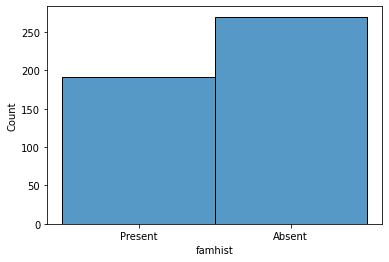

In [9]:
sns.histplot(x='famhist', data=heart)

## Preprocessing

In [55]:
numeric_columns = heart.columns
cat_columns = ['famhist']

numeric_pipeline = Pipeline(
    [
        ('power transformer', PowerTransformer(method='yeo-johnson', standardize=True))
    ]
)

cat_pipeline = Pipeline(
    [
        ('ordinal encoding', OrdinalEncoder())
    ]
)

full_pipeline = Pipeline(
    [
        ('categoric pipeline', cat_pipeline),
        ('numeric pipeline', numeric_pipeline)
    ]
)

In [56]:
heart_preproc = pd.DataFrame(full_pipeline.fit_transform(heart), columns=heart.columns)

array([[<AxesSubplot:title={'center':'sbp'}>,
        <AxesSubplot:title={'center':'tobacco'}>,
        <AxesSubplot:title={'center':'ldl'}>],
       [<AxesSubplot:title={'center':'adiposity'}>,
        <AxesSubplot:title={'center':'famhist'}>,
        <AxesSubplot:title={'center':'typea'}>],
       [<AxesSubplot:title={'center':'obesity'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'chd'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

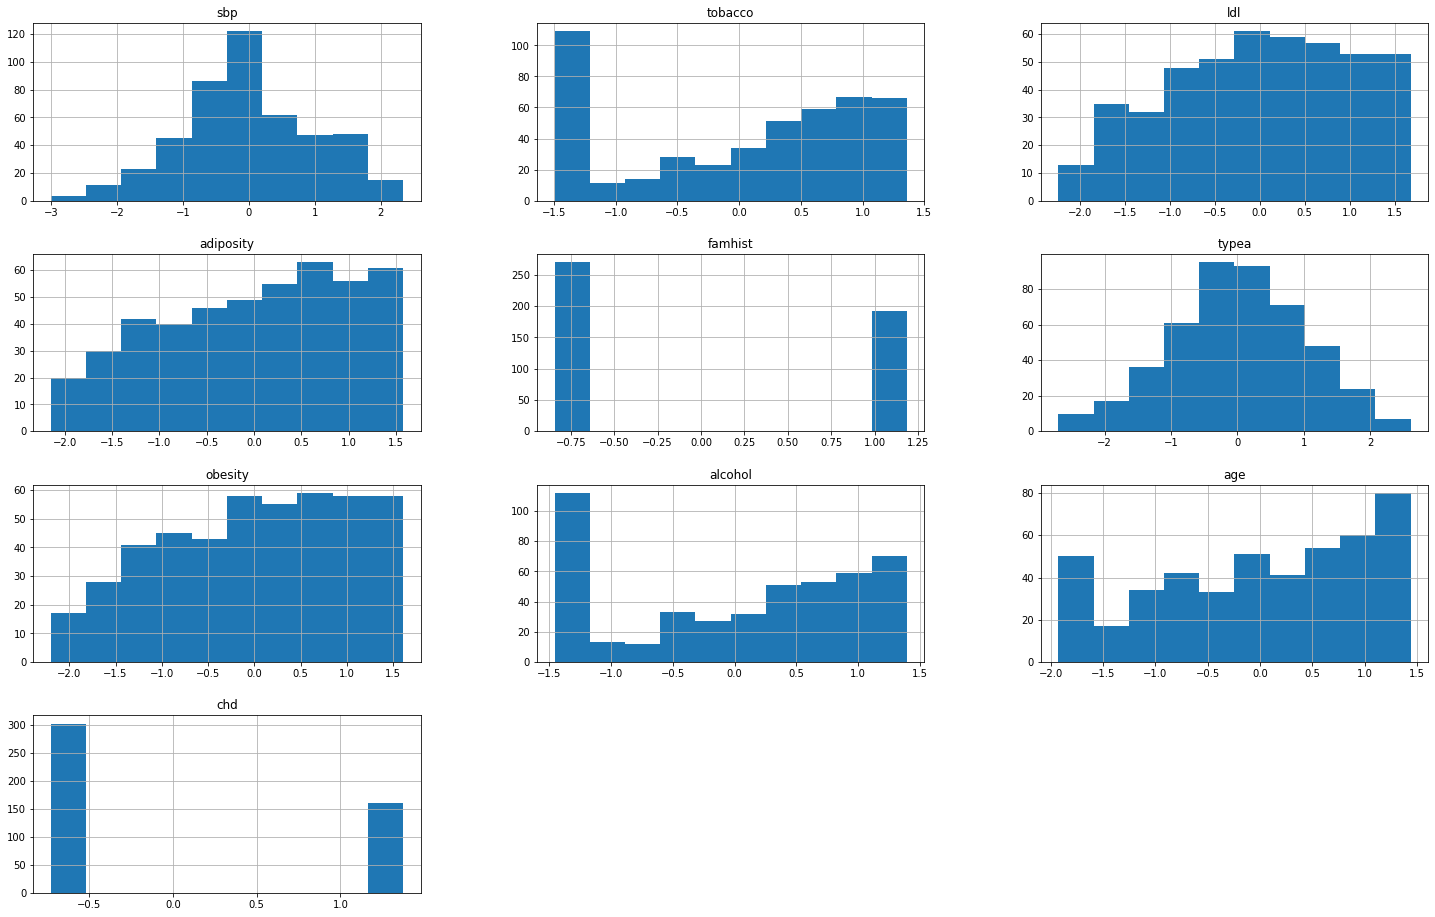

In [57]:
heart_preproc.hist(ax = plt.figure(figsize=(25, 16)).gca())

### Correlations

<AxesSubplot:>

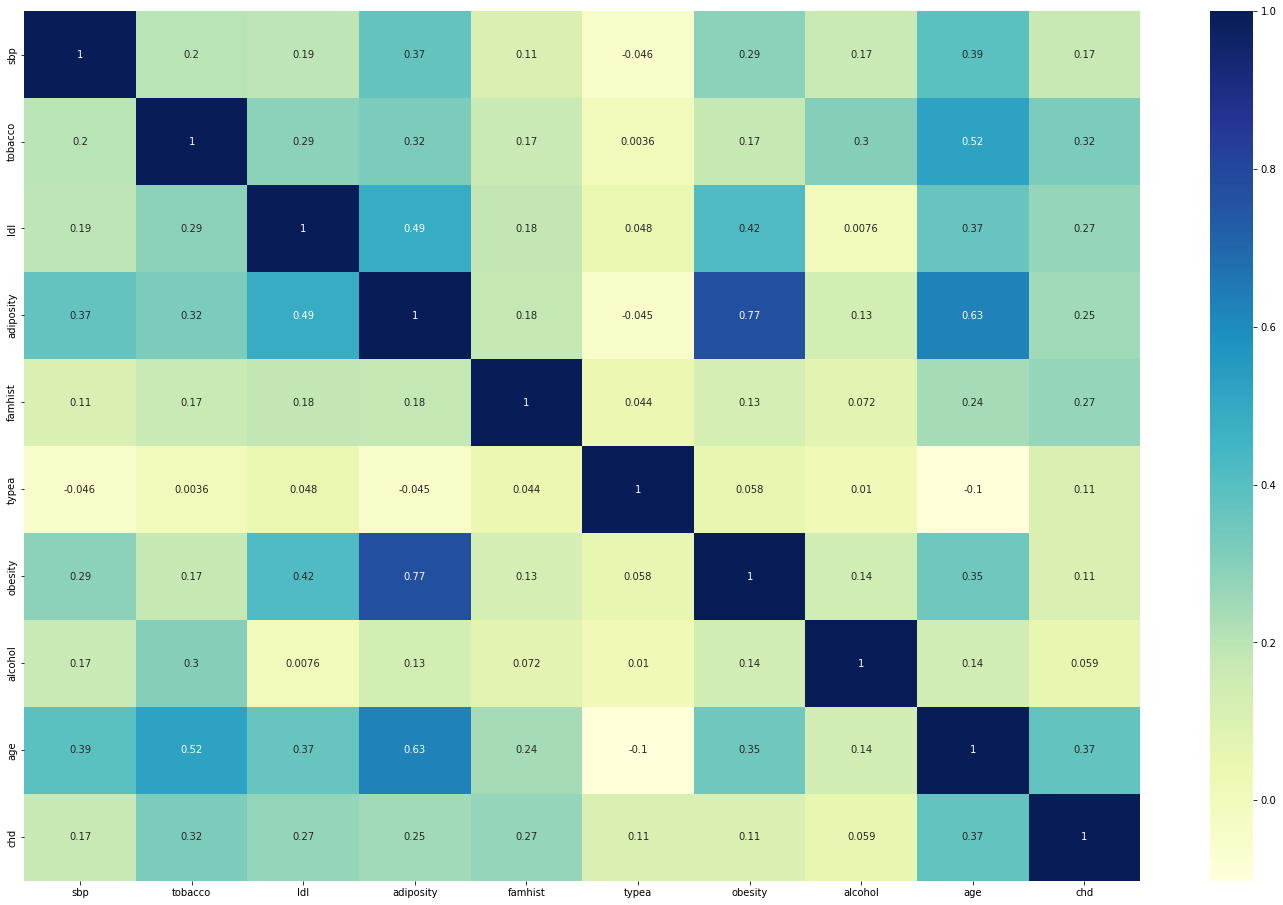

In [58]:
sns.heatmap(heart_preproc.corr(), cmap='YlGnBu', annot=True, ax=plt.figure(figsize=(25, 16)).gca())

In [59]:
high_correlaitons = pd.DataFrame(columns=['col1', 'col2', 'corr'])
threshold = .5

correlations = heart_preproc.corr()
for i in range(correlations.shape[0]):
    for j in range(i+1, correlations.shape[1]):
        if abs(correlations.iloc[i, j]) > threshold:
            vars = {'col1':correlations.columns[i], 'col2':correlations.columns[j], 'corr':correlations.iloc[i, j]}
            high_correlaitons = high_correlaitons.append(vars, ignore_index = True)

In [60]:
high_correlaitons

,col1,col2,corr
0,tobacco,age,0.524806
1,adiposity,obesity,0.772772
2,adiposity,age,0.629487


## PCA decomposition

In [67]:
%%capture

pca = PCA()
pca.fit(heart_preproc)

pca_names = ['PCA' + str(i) for i in range(1, pca.n_features_ + 1)]

### Biplot

In [ ]:
# cluster.biplot(
#     cscore=PCA().fit_transform(heart_preproc),
#     loadings=pca.components_,
#     labels=heart.columns.values,
#     var1=round(pca.explained_variance_ratio_[0]*100, 2),
#     var2=round(pca.explained_variance_ratio_[1]*100, 2), 
# )

![img](../resources/imgs/biplot_2d.png)

### Variance raio plots

Text(0.5, 1.0, 'Expalined variance ratio')

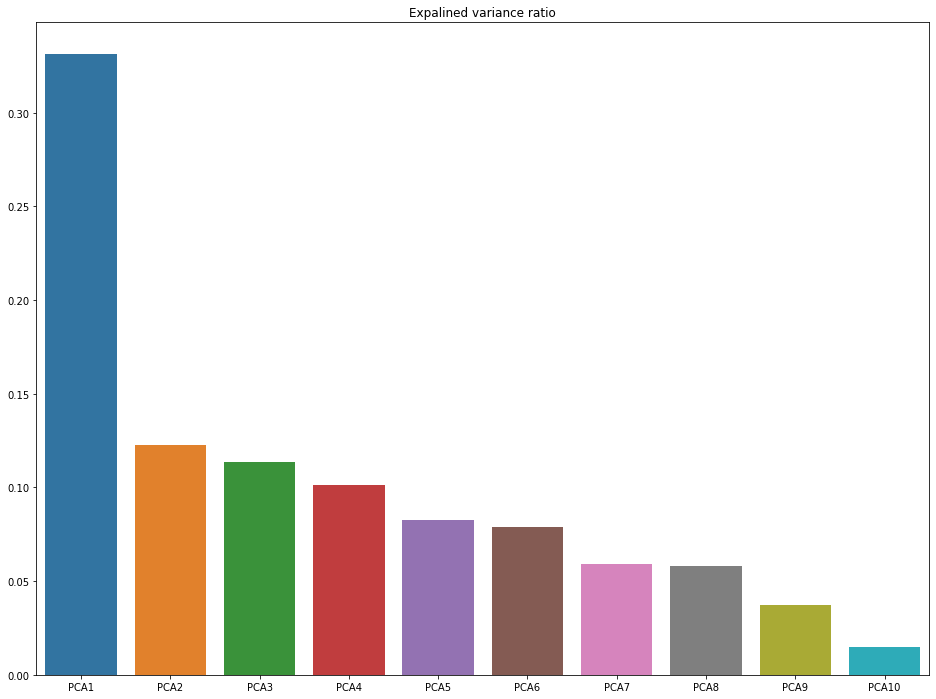

In [85]:
sns.barplot(x=pca_names, y=pca.explained_variance_ratio_, ax=plt.figure(figsize=(16, 12)).gca()).set_title("Expalined variance ratio")

Text(0.5, 1.0, 'cumulative varaince explained')

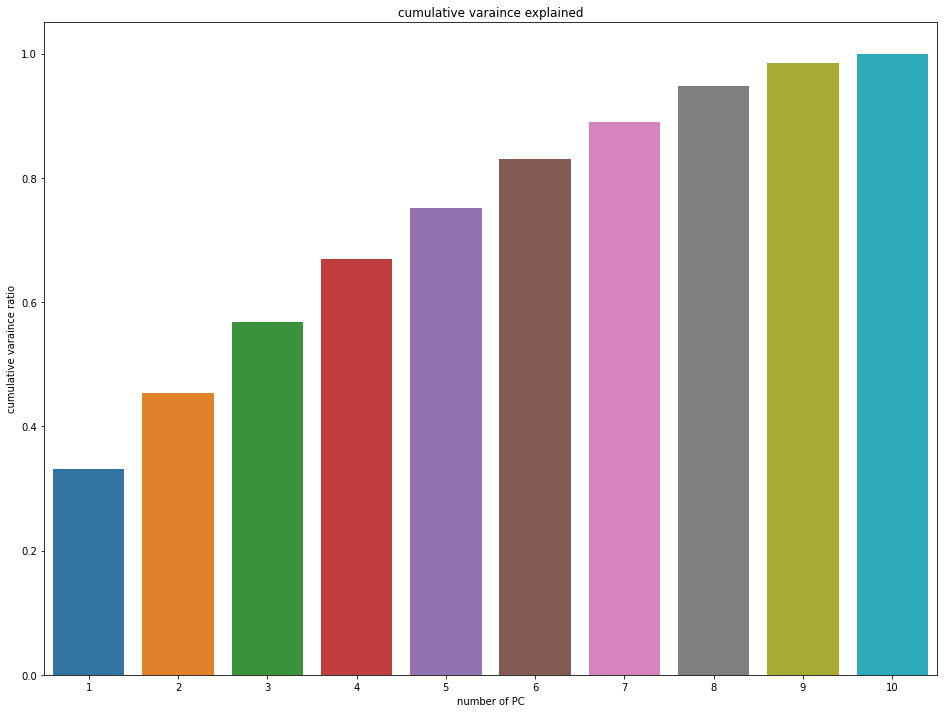

In [93]:
cum_df = pd.DataFrame(data=
{
    'number of PC':[i for i in range(1, pca.n_features_ + 1)],
    'cumulative varaince ratio':np.cumsum(pca.explained_variance_ratio_),
    'variance ratio':pca.explained_variance_ratio_
}
)

sns.barplot(x='number of PC', y='cumulative varaince ratio', data=cum_df, ax=plt.figure(figsize=(16, 12)).gca()).set_title('cumulative varaince explained')

In [102]:
def show_min_variance(threshold):
    min_pc = np.min(cum_df.loc[cum_df['cumulative varaince ratio'] > threshold]['number of PC'])
    print(f'Minimal number of PC to explain {threshold*100:.2f}% of variance: {min_pc}')
    return min_pc

def show_min_change(threshold):
    min_add_pc = np.min(cum_df.loc[cum_df['variance ratio'] < threshold]['number of PC']) - 1
    print(f'Last PC which explain more than {threshold*100:.2f}% of variance: {min_add_pc}')
    return min_add_pc

In [105]:
show_min_variance(.75)
show_min_variance(.9)
show_min_change(.1)
show_min_change(.05)

Minimal number of PC to explain 75.00% of variance: 5
Minimal number of PC to explain 90.00% of variance: 8
Last PC which explain more than 10.00% of variance: 4
Last PC which explain more than 5.00% of variance: 8


8

## Conclusions

Based on plots and calculations, around 5 PC sholud be chosen, as they explain more than 75% of the variance, yet still reduce number of dimensions to 5 out of 10. If greater explanaiton level is required, one should consider reducing dimensions to 8, as it still exlpain more than 90% of the varaince.